# Practical session 1
>  - María Castro
>  - Jorge Martín
>  - Miguel Angel Rojas


## Import library

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Functions

In [2]:
#separate train and test train_test_split function' 
def train_test_split_local(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    train_test_split(y, shuffle=False)
    return X_train, X_test, y_train, y_test

def read(file_name, fheader, fuser, ftrial):
    fsadl1 = pd.read_csv(file_name, sep=' ', header=None)
    fdata = fsadl1.iloc[:, :243]
    fdata.columns = fheader
    fdata=fdata[fdata.columns[np.r_[0:45,50:58,63:71,76:84,89:97,102:133]]]
    flabels = fsadl1.iloc[:,243]
    ## Preprocessing data
    #find and remove rows with all nulls
    fidx=fdata.index[fdata.isnull().all(1)] #1 is the axis for rows
    #select data not in idx, that is data that is not all null
    fdata = fdata[~fdata.index.isin(fidx)] 
    #same for labels
    flabels = flabels[~flabels.index.isin(fidx)]

    #see how many there are of each label
    #what does it mean ?
    flabels.value_counts()


    #fill missing values
    fdata = fdata.fillna(method='ffill',axis=1)


    fdata['user'] = fuser
    fdata['trial'] = ftrial
    return fdata, flabels
    
def windowing(fdata, window_number, window_text, porcentage, flabels, frol):
    ffiltered_data = fdata[columns].rolling(frol).median()
    ffiltered_data['MILLISEC'] = fdata.MILLISEC


    # Windowing and Feature Extraction
    ffiltered_data['time']=pd.to_datetime(fdata.MILLISEC,unit='ms')
    ffiltered_data.index=ffiltered_data.time
    #calculate mean over a 1 second window
    keep = ffiltered_data.time.dt.microsecond/window_number %porcentage
    keep = keep - keep.shift() < 0

    means = ffiltered_data[columns].rolling(window_text).mean()[keep]
    means.columns = [str(col) + '_mean' for col in means.columns]
    variances = ffiltered_data[columns].rolling(window_text).var()[keep]
    variances.columns = [str(col) + '_var' for col in variances.columns]

    #talk about apply function
    flabels.index = ffiltered_data.time
    mode_labels = flabels.rolling(window_text).apply(lambda x:mode(x)[0])[keep]

    #all features
    fall_features = pd.concat([means, variances],axis=1)
    fall_features['label'] = mode_labels
    fall_features['user'] = user
    fall_features['trial'] = trial
    
    return fall_features

def plot_confusion_matrix(cm, names, title='MATRIZ DE CONFUSIÓN', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Clase real')
    plt.xlabel('Clase predicha')



## Execises definitions and clasifiers


In [3]:
def excercise_1 (fall_data, estimators):
    # Exercise 1
    # Random train test split

    # Labels are the values we want to predict
    labels = np.array(fall_data['label'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features = fall_data.drop('label', axis = 1)
    features = features.drop('user', axis = 1)
    features = features.drop('trial', axis = 1)


    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)


    X_train, X_test, y_train, y_test = train_test_split_local(features, labels)

    print('X_train:', X_train.shape)
    print('X_test:', X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:', y_test.shape)


    classifier = RandomForestClassifier(n_estimators=estimators, random_state=0)  
    classifier.fit(X_train, y_train)  
    y_pred = classifier.predict(X_test)
    
    labels = [0,1,2,4,5]

    print("\n _______________________________________________________")  
    print("confusion matrix: \n")  
    print(confusion_matrix(y_test,y_pred))  
    print("\n _______________________________________________________")  
    print("classification report: \n")  
    print(classification_report(y_test,y_pred))  
    print("_______________________________________________________")  
    print("accuracy score: " + str(accuracy_score(y_test, y_pred)))  

    
    plt.figure(figsize=(15,8))
    plot_confusion_matrix(confusion_matrix(y_test,y_pred), labels)

def excercise_2 (fall_data, estimators):
    # Excercise 2
    # user 1 2 3 train test 4

    # Labels are the values we want to predict
    # Remove the labels from the features
    # axis 1 refers to the columns

    user123 = fall_data[fall_data['user'].isin([1, 2, 3])]
    user4 = fall_data[fall_data['user'].isin([4])]


    y_train_2 = np.array(user123['label'])
    y_test_2 = np.array(user4['label'])

    user123 = user123.drop('label', axis = 1)
    user123 = user123.drop('user', axis = 1)
    user123 = user123.drop('trial', axis = 1)

    user4 = user4.drop('label', axis = 1)
    user4 = user4.drop('user', axis = 1)
    user4 = user4.drop('trial', axis = 1)

    X_train_2 = np.array(user123)
    X_test_2 = np.array(user4)
    print('X_train_2:', X_train_2.shape)
    print('X_test_2:', X_test_2.shape)
    print('y_train_2:', y_train_2.shape)
    print('y_test_2:', y_test_2.shape)


    classifier2 = RandomForestClassifier(n_estimators=estimators, random_state=0)  
    classifier2.fit(X_train_2, y_train_2)  
    y_pred_2 = classifier2.predict(X_test_2)

    print("\n _______________________________________________________")  
    print("confusion matrix: \n")  
    print(confusion_matrix(y_test_2,y_pred_2))  
    print("\n _______________________________________________________")  
    print("classification report: \n")  
    print(classification_report(y_test_2,y_pred_2))  
    print("_______________________________________________________")  
    print("accuracy score: " +str(accuracy_score(y_test_2, y_pred_2)))

    labels = [0,1,2,4,5]
    plt.figure(figsize=(15,8))
    plot_confusion_matrix(confusion_matrix(y_test_2,y_pred_2), labels)

def excercise_3 (fall_data, estimators):  
    # Excercise 3
    #  1,2,3 and drill session as training data and trials 4 and 5 as test data.

    # Labels are the values we want to predict
    # Remove the labels from the features
    # axis 1 refers to the columns

    trial1236 = fall_data[fall_data['trial'].isin([1, 2, 3, 6])]
    trial45 = fall_data[fall_data['trial'].isin([4, 5])]

    y_train_3 = np.array(trial1236['label'])
    y_test_3 = np.array(trial45['label'])

    trial1236 = trial1236.drop('label', axis = 1)
    trial1236 = trial1236.drop('user', axis = 1)
    trial1236 = trial1236.drop('trial', axis = 1)

    trial45 = trial45.drop('label', axis = 1)
    trial45 = trial45.drop('user', axis = 1)
    trial45 = trial45.drop('trial', axis = 1)

    X_train_3 = np.array(trial1236)
    X_test_3 = np.array(trial45)

    print('X_train_3:', X_train_3.shape)
    print('X_test_3:', X_test_3.shape)
    print('y_train_3:', y_train_3.shape)
    print('y_test_3:', y_test_3.shape)


    classifier = RandomForestClassifier(n_estimators=estimators, random_state=0)  
    classifier.fit(X_train_3, y_train_3)  
    y_pred_3 = classifier.predict(X_test_3)


    print("\n _______________________________________________________")  
    print("confusion matrix: \n")  
    print(confusion_matrix(y_test_3,y_pred_3))  
    print("\n _______________________________________________________")  
    print("classification report: \n")  
    print(classification_report(y_test_3,y_pred_3))  
    print("_______________________________________________________")  
    print("accuracy score: " + str(accuracy_score(y_test_3, y_pred_3)))

    labels = [0,1,2,4,5]
    plt.figure(figsize=(15,8))
    plot_confusion_matrix(confusion_matrix(y_test_3,y_pred_3), labels)

## Read data

In [6]:

path = 'dataset/' #enter thepath for the dataset folder
header_path = 'header.csv' #enter the path for the header file
header=pd.read_csv(header_path,names=['column',''])['column'].values
users = range(1,2)
trials = range(1,2)
all_data_1S = pd.DataFrame()
all_data_2S = pd.DataFrame()
all_data_5S = pd.DataFrame()
all_data_10S = pd.DataFrame()

In [7]:
for user in users:
    for trial in trials:
        if trial == 6:
            file_name = path+'S'+str(user)+'-Drill'+'.dat'
        else:
            file_name = path+'S'+str(user)+'-ADL'+str(trial)+'.dat'
        data, labels = read(file_name, header, user, trial)
        columns = data.columns[~data.columns.isin(['user', 'trial','MILLISEC'])]
        #we use a window of 11 elements
        # Filtering using median filter
        
        all_features_1S = windowing(data, 1000, '1S', 500, labels, 11)
        all_data_1S = pd.concat([all_data_1S, all_features_1S])
        
        all_features_2S = windowing(data, 2000, '2S', 1000, labels, 11)
        all_data_2S = pd.concat([all_data_2S, all_features_2S])
        
        all_features_5S = windowing(data, 5000, '5S', 2500, labels, 11)
        all_data_5S = pd.concat([all_data_5S, all_features_5S])
        
        all_features_10S = windowing(data, 10000, '10S', 5000, labels, 11)
        all_data_10S = pd.concat([all_data_10S, all_features_10S])

    

/Users/yure/Documents/UN/Machine Learning/ml/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


## Exploratory data analysis

In [8]:
data.describe()

,MILLISEC,Accelerometer_RKN^_accX,Accelerometer_RKN^_accY,Accelerometer_RKN^_accZ,Accelerometer_HIP_accX,Accelerometer_HIP_accY,Accelerometer_HIP_accZ,Accelerometer_LUA^_accX,Accelerometer_LUA^_accY,Accelerometer_LUA^_accZ,...,InertialMeasurementUnit_R-SHOE_Body_Ay,InertialMeasurementUnit_R-SHOE_Body_Az,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameX,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameY,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameZ,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameX,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameY,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameZ,user,trial
count,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,...,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,5.111600e+04,51116.0,51116.0
mean,8.519081e+05,2.548977e+04,2.623697e+04,2.572849e+04,1.414811e+04,1.524655e+04,1.449286e+04,1.436907e+04,1.521204e+04,1.443007e+04,...,1.395987e+03,1.943798e+02,9.312527e+02,9.414940e+02,9.120239e+02,9.414940e+02,9.348659e+02,9.120239e+02,1.0,1.0
std,4.918638e+05,1.946733e+05,1.945755e+05,1.946426e+05,1.551530e+05,1.550517e+05,1.551212e+05,1.551329e+05,1.550550e+05,1.551271e+05,...,3.984791e+04,3.987572e+04,3.988644e+04,3.986382e+04,3.986828e+04,3.986382e+04,3.988635e+04,3.986828e+04,0.0,0.0
min,0.000000e+00,-3.955000e+03,-4.288000e+03,-6.519000e+03,-1.330000e+03,-2.360000e+02,-7.490000e+02,-1.671000e+03,-6.000000e+02,-1.440000e+03,...,-5.968000e+03,-7.233000e+03,-2.156100e+04,-9.677000e+03,-9.443000e+03,-9.677000e+03,-1.278600e+04,-9.443000e+03,1.0,1.0
25%,4.259538e+05,-1.440000e+02,5.480000e+02,-3.550000e+02,-2.640000e+02,9.310000e+02,9.200000e+01,-7.600000e+01,8.740000e+02,1.000000e+00,...,3.350000e+02,-8.430000e+02,-4.500000e+01,-4.400000e+01,-2.600000e+01,-4.400000e+01,-3.300000e+01,-2.600000e+01,1.0,1.0
50%,8.519080e+05,-2.700000e+01,9.200000e+02,3.210000e+02,-1.020000e+02,9.840000e+02,1.780000e+02,1.060000e+02,9.700000e+02,9.300000e+01,...,3.520000e+02,-8.250000e+02,-2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.0,1.0
75%,1.277862e+06,7.900000e+01,9.840000e+02,6.470000e+02,-2.300000e+01,1.011000e+03,2.710000e+02,2.440000e+02,1.009000e+03,2.270000e+02,...,4.580000e+02,-7.630000e+02,3.300000e+01,3.600000e+01,3.600000e+01,3.600000e+01,4.500000e+01,3.600000e+01,1.0,1.0
max,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,...,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,1.703816e+06,1.0,1.0


In [11]:
data.dtypes

MILLISEC                                            float64
Accelerometer_RKN^_accX                             float64
Accelerometer_RKN^_accY                             float64
Accelerometer_RKN^_accZ                             float64
Accelerometer_HIP_accX                              float64
Accelerometer_HIP_accY                              float64
Accelerometer_HIP_accZ                              float64
Accelerometer_LUA^_accX                             float64
Accelerometer_LUA^_accY                             float64
Accelerometer_LUA^_accZ                             float64
Accelerometer_RUA__accX                             float64
Accelerometer_RUA__accY                             float64
Accelerometer_RUA__accZ                             float64
Accelerometer_LH_accX                               float64
Accelerometer_LH_accY                               float64
Accelerometer_LH_accZ                               float64
Accelerometer_BACK_accX                 

In [9]:
%matplotlib inline

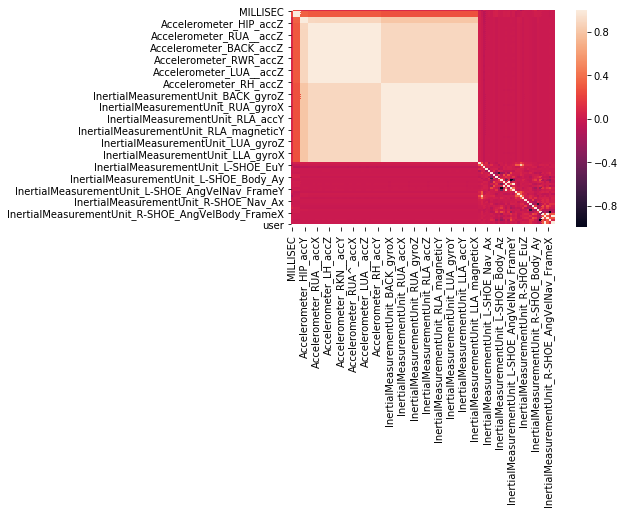

In [11]:
# Correlaton matrix to identify principal sensor 
sns.heatmap(data.corr())

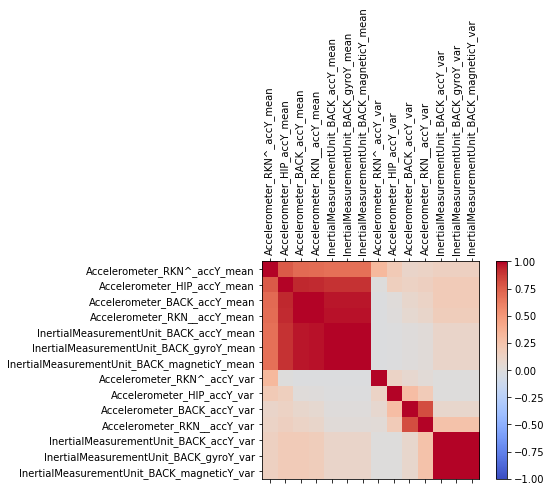

In [12]:
features_analisys = all_data_1S.filter(['Accelerometer_RKN^_accY_mean',
'Accelerometer_HIP_accY_mean',
'Accelerometer_BACK_accY_mean',
'Accelerometer_RKN__accY_mean',
'InertialMeasurementUnit_BACK_accY_mean',
'InertialMeasurementUnit_BACK_gyroY_mean',
'InertialMeasurementUnit_BACK_magneticY_mean',
'Accelerometer_RKN^_accY_var',
'Accelerometer_HIP_accY_var',
'Accelerometer_BACK_accY_var',
'Accelerometer_RKN__accY_var',
'InertialMeasurementUnit_BACK_accY_var',
'InertialMeasurementUnit_BACK_gyroY_var',
'InertialMeasurementUnit_BACK_magneticY_var'
], axis=1)
corr = features_analisys.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(features_analisys.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(features_analisys.columns)
ax.set_yticklabels(features_analisys.columns)
plt.show()

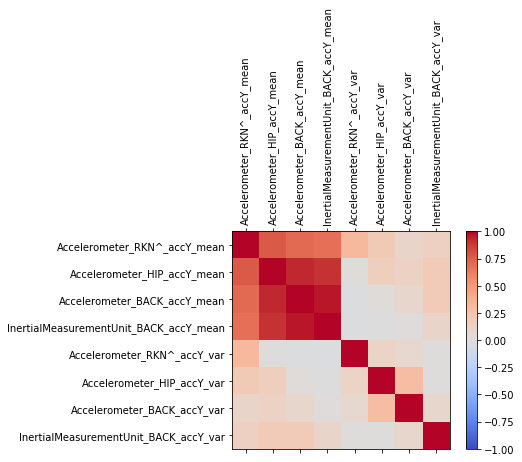

In [13]:
features_analisys = all_data_1S.filter(['Accelerometer_RKN^_accY_mean',
'Accelerometer_HIP_accY_mean',
'Accelerometer_BACK_accY_mean',
'InertialMeasurementUnit_BACK_accY_mean',
'Accelerometer_RKN^_accY_var',
'Accelerometer_HIP_accY_var',
'Accelerometer_BACK_accY_var',
'InertialMeasurementUnit_BACK_accY_var'
], axis=1)
corr = features_analisys.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(features_analisys.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(features_analisys.columns)
ax.set_yticklabels(features_analisys.columns)
plt.show()

In [14]:
all_data_1S_filtered = all_data_1S.filter(['Accelerometer_RKN^_accY_mean',
'Accelerometer_HIP_accY_mean',
'Accelerometer_BACK_accY_mean',
'InertialMeasurementUnit_BACK_accY_mean',
'Accelerometer_RKN^_accY_var',
'Accelerometer_HIP_accY_var',
'Accelerometer_BACK_accY_var',
'InertialMeasurementUnit_BACK_accY_var',
'label',
'user',
'trial'
], axis=1)

all_data_2S_filtered = all_data_2S.filter(['Accelerometer_RKN^_accY_mean',
'Accelerometer_HIP_accY_mean',
'Accelerometer_BACK_accY_mean',
'InertialMeasurementUnit_BACK_accY_mean',
'Accelerometer_RKN^_accY_var',
'Accelerometer_HIP_accY_var',
'Accelerometer_BACK_accY_var',
'InertialMeasurementUnit_BACK_accY_var',
'label',
'user',
'trial'
], axis=1)

all_data_5S_filtered = all_data_5S.filter(['Accelerometer_RKN^_accY_mean',
'Accelerometer_HIP_accY_mean',
'Accelerometer_BACK_accY_mean',
'InertialMeasurementUnit_BACK_accY_mean',
'Accelerometer_RKN^_accY_var',
'Accelerometer_HIP_accY_var',
'Accelerometer_BACK_accY_var',
'InertialMeasurementUnit_BACK_accY_var',
'label',
'user',
'trial'
], axis=1)

all_data_10S_filtered = all_data_10S.filter(['Accelerometer_RKN^_accY_mean',
'Accelerometer_HIP_accY_mean',
'Accelerometer_BACK_accY_mean',
'InertialMeasurementUnit_BACK_accY_mean',
'Accelerometer_RKN^_accY_var',
'Accelerometer_HIP_accY_var',
'Accelerometer_BACK_accY_var',
'InertialMeasurementUnit_BACK_accY_var',
'label',
'user',
'trial'
], axis=1)

In [15]:
print("\n _______________________________________________________")  
print(all_data_1S_filtered.head())
print("\n _______________________________________________________")  
print(all_data_2S_filtered.head())
print("\n _______________________________________________________")  
print(all_data_5S_filtered.head())
print("\n _______________________________________________________")  
print(all_data_10S_filtered.head())


 _______________________________________________________
                         Accelerometer_RKN^_accY_mean  \
time                                                    
1970-01-01 00:00:00.500                    961.666667   
1970-01-01 00:00:01.000                    975.000000   
1970-01-01 00:00:01.500                    989.700000   
1970-01-01 00:00:02.000                    992.066667   
1970-01-01 00:00:02.500                    991.933333   

                         Accelerometer_HIP_accY_mean  \
time                                                   
1970-01-01 00:00:00.500                  1023.166667   
1970-01-01 00:00:01.000                  1005.666667   
1970-01-01 00:00:01.500                  1007.933333   
1970-01-01 00:00:02.000                  1018.166667   
1970-01-01 00:00:02.500                  1018.566667   

                         Accelerometer_BACK_accY_mean  \
time                                                    
1970-01-01 00:00:00.500            

In [16]:
print("\n _______________________________________________________")  
print(all_data_1S_filtered.label.value_counts())
print("\n _______________________________________________________")  
print(all_data_2S_filtered.label.value_counts())
print("\n _______________________________________________________")  
print(all_data_5S_filtered.label.value_counts())
print("\n _______________________________________________________")  
print(all_data_10S_filtered.label.value_counts())


 _______________________________________________________
1.0    23172
2.0    13218
0.0    10747
4.0     9119
5.0     1692
Name: label, dtype: int64

 _______________________________________________________
1.0    11558
2.0     6633
0.0     5368
4.0     4565
5.0      844
Name: label, dtype: int64

 _______________________________________________________
1.0    11796
2.0     6378
0.0     5326
4.0     4607
5.0      861
Name: label, dtype: int64

 _______________________________________________________
1.0    12483
2.0     5500
0.0     5354
4.0     4703
5.0      928
Name: label, dtype: int64


In [17]:
print("\n _______________________________________________________")  
print(all_data_1S_filtered.trial.value_counts())
print("\n _______________________________________________________")  
print(all_data_2S_filtered.trial.value_counts())
print("\n _______________________________________________________")  
print(all_data_5S_filtered.trial.value_counts())
print("\n _______________________________________________________")  
print(all_data_10S_filtered.trial.value_counts())


 _______________________________________________________
6    14981
1    11513
3     7956
5     7930
2     7863
4     7705
Name: trial, dtype: int64

 _______________________________________________________
6    7490
1    5755
3    3977
5    3964
2    3931
4    3851
Name: trial, dtype: int64

 _______________________________________________________
6    7490
1    5755
3    3977
5    3964
2    3931
4    3851
Name: trial, dtype: int64

 _______________________________________________________
6    7490
1    5755
3    3977
5    3964
2    3931
4    3851
Name: trial, dtype: int64


In [18]:
print("\n _______________________________________________________")  
print(all_data_1S_filtered.user.value_counts())
print("\n _______________________________________________________")  
print(all_data_2S_filtered.user.value_counts())
print("\n _______________________________________________________")  
print(all_data_5S_filtered.user.value_counts())
print("\n _______________________________________________________")  
print(all_data_10S_filtered.user.value_counts())


 _______________________________________________________
1    15641
2    15010
3    14455
4    12842
Name: user, dtype: int64

 _______________________________________________________
1    7820
2    7503
3    7226
4    6419
Name: user, dtype: int64

 _______________________________________________________
1    7820
2    7503
3    7226
4    6419
Name: user, dtype: int64

 _______________________________________________________
1    7820
2    7503
3    7226
4    6419
Name: user, dtype: int64


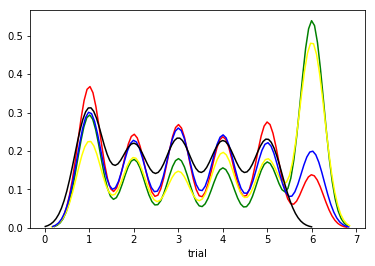

In [19]:
#separate by class, see feature mean
all_data_1S_0 = all_data_1S_filtered[all_data_1S_filtered.label==0]
all_data_1S_1 = all_data_1S_filtered[all_data_1S_filtered.label==1]
all_data_1S_2 = all_data_1S_filtered[all_data_1S_filtered.label==2]
all_data_1S_4 = all_data_1S_filtered[all_data_1S_filtered.label==4]
all_data_1S_5 = all_data_1S_filtered[all_data_1S_filtered.label==5]

draw_col = 10
sns.distplot(all_data_1S_0.iloc[:,draw_col], hist=False, kde=True, color='red')
sns.distplot(all_data_1S_1.iloc[:,draw_col], hist=False, kde=True, color='green')
sns.distplot(all_data_1S_2.iloc[:,draw_col], hist=False, kde=True, color='yellow')
sns.distplot(all_data_1S_4.iloc[:,draw_col], hist=False, kde=True, color='blue')
sns.distplot(all_data_1S_5.iloc[:,draw_col], hist=False, kde=True, color='black')

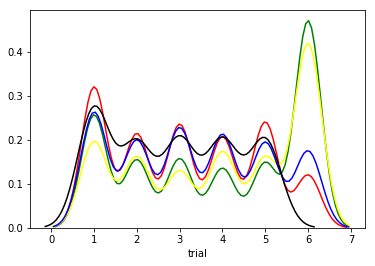

In [20]:
#separate by class, see feature mean
all_data_2S_0 = all_data_2S_filtered[all_data_2S_filtered.label==0]
all_data_2S_1 = all_data_2S_filtered[all_data_2S_filtered.label==1]
all_data_2S_2 = all_data_2S_filtered[all_data_2S_filtered.label==2]
all_data_2S_4 = all_data_2S_filtered[all_data_2S_filtered.label==4]
all_data_2S_5 = all_data_2S_filtered[all_data_2S_filtered.label==5]

draw_col = 10
sns.distplot(all_data_2S_0.iloc[:,draw_col], hist=False, kde=True, color='red')
sns.distplot(all_data_2S_1.iloc[:,draw_col], hist=False, kde=True, color='green')
sns.distplot(all_data_2S_2.iloc[:,draw_col], hist=False, kde=True, color='yellow')
sns.distplot(all_data_2S_4.iloc[:,draw_col], hist=False, kde=True, color='blue')
sns.distplot(all_data_2S_5.iloc[:,draw_col], hist=False, kde=True, color='black')

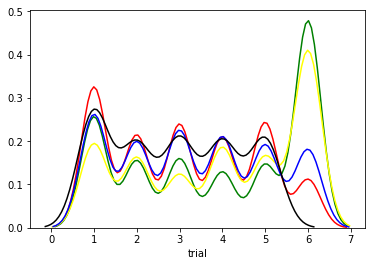

In [21]:
#separate by class, see feature mean
all_data_5S_0 = all_data_5S_filtered[all_data_5S_filtered.label==0]
all_data_5S_1 = all_data_5S_filtered[all_data_5S_filtered.label==1]
all_data_5S_2 = all_data_5S_filtered[all_data_5S_filtered.label==2]
all_data_5S_4 = all_data_5S_filtered[all_data_5S_filtered.label==4]
all_data_5S_5 = all_data_5S_filtered[all_data_5S_filtered.label==5]

draw_col = 10
sns.distplot(all_data_5S_0.iloc[:,draw_col], hist=False, kde=True, color='red')
sns.distplot(all_data_5S_1.iloc[:,draw_col], hist=False, kde=True, color='green')
sns.distplot(all_data_5S_2.iloc[:,draw_col], hist=False, kde=True, color='yellow')
sns.distplot(all_data_5S_4.iloc[:,draw_col], hist=False, kde=True, color='blue')
sns.distplot(all_data_5S_5.iloc[:,draw_col], hist=False, kde=True, color='black')

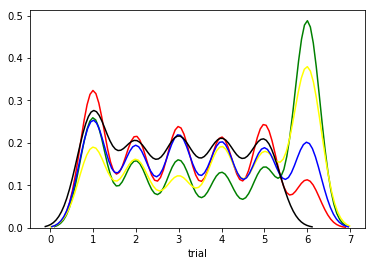

In [22]:
#separate by class, see feature mean
all_data_10S_0 = all_data_10S_filtered[all_data_10S_filtered.label==0]
all_data_10S_1 = all_data_10S_filtered[all_data_10S_filtered.label==1]
all_data_10S_2 = all_data_10S_filtered[all_data_10S_filtered.label==2]
all_data_10S_4 = all_data_10S_filtered[all_data_10S_filtered.label==4]
all_data_10S_5 = all_data_10S_filtered[all_data_10S_filtered.label==5]

draw_col = 10
sns.distplot(all_data_10S_0.iloc[:,draw_col], hist=False, kde=True, color='red')
sns.distplot(all_data_10S_1.iloc[:,draw_col], hist=False, kde=True, color='green')
sns.distplot(all_data_10S_2.iloc[:,draw_col], hist=False, kde=True, color='yellow')
sns.distplot(all_data_10S_4.iloc[:,draw_col], hist=False, kde=True, color='blue')
sns.distplot(all_data_10S_5.iloc[:,draw_col], hist=False, kde=True, color='black')

## Metrics

#############################
X_train: (38825, 8)
X_test: (19123, 8)
y_train: (38825,)
y_test: (19123,)

 _______________________________________________________
confusion matrix: 

[[2604  535  340   51   11]
 [ 261 6668  628   54    1]
 [ 261  989 3173   18    0]
 [  46   87   24 2788    8]
 [   8    2    1    8  557]]

 _______________________________________________________
classification report: 

              precision    recall  f1-score   support

         0.0       0.82      0.74      0.77      3541
         1.0       0.81      0.88      0.84      7612
         2.0       0.76      0.71      0.74      4441
         4.0       0.96      0.94      0.95      2953
         5.0       0.97      0.97      0.97       576

   micro avg       0.83      0.83      0.83     19123
   macro avg       0.86      0.85      0.85     19123
weighted avg       0.83      0.83      0.82     19123

_______________________________________________________
accuracy score: 0.8257072635046803
##############

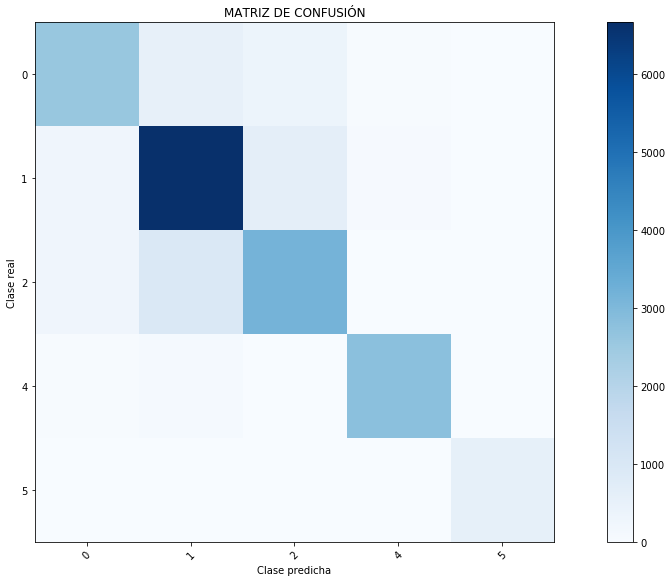

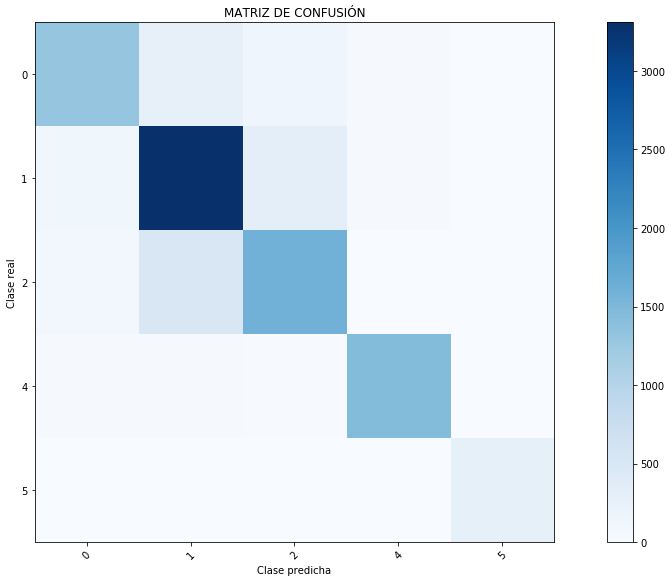

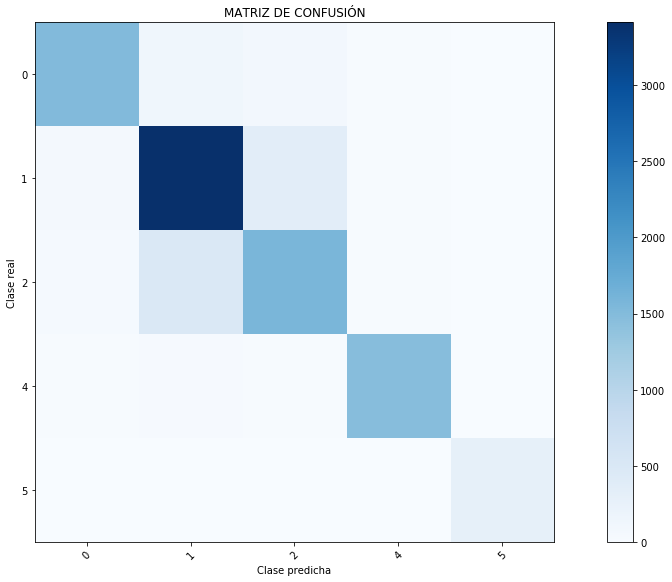

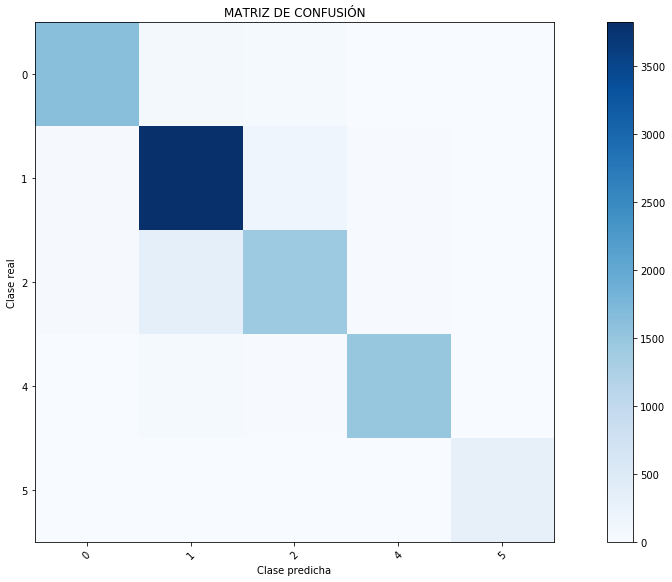

In [23]:
print("#############################")
excercise_1(all_data_1S_filtered, 50)
print("#############################")
excercise_1(all_data_2S_filtered, 50)
print("#############################")
excercise_1(all_data_5S_filtered, 50)
print("#############################")
excercise_1(all_data_10S_filtered, 50)
print("#############################")

#############################
X_train_2: (45106, 8)
X_test_2: (12842, 8)
y_train_2: (45106,)
y_test_2: (12842,)

 _______________________________________________________
confusion matrix: 

[[1168 1479  358   31    0]
 [ 208 4060  803   48    0]
 [ 340  857 1555    1    0]
 [  89  171   37 1284    0]
 [  50   17    0  175  111]]

 _______________________________________________________
classification report: 

              precision    recall  f1-score   support

         0.0       0.63      0.38      0.48      3036
         1.0       0.62      0.79      0.69      5119
         2.0       0.56      0.56      0.56      2753
         4.0       0.83      0.81      0.82      1581
         5.0       1.00      0.31      0.48       353

   micro avg       0.64      0.64      0.64     12842
   macro avg       0.73      0.57      0.61     12842
weighted avg       0.65      0.64      0.63     12842

_______________________________________________________
accuracy score: 0.6368166952188132
######

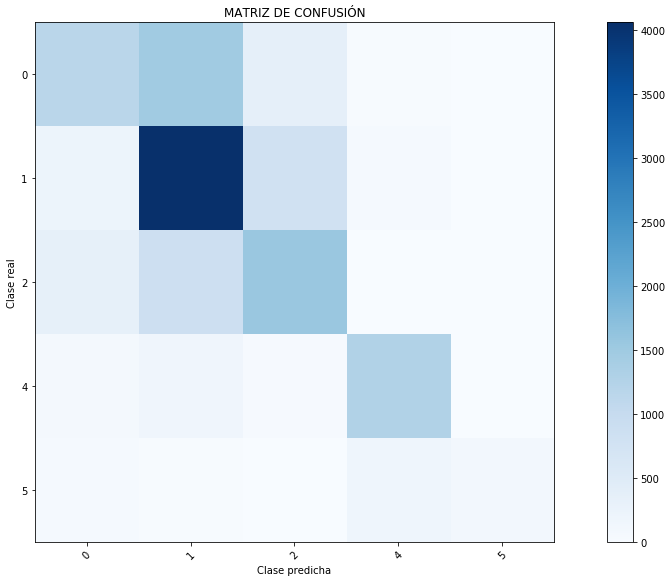

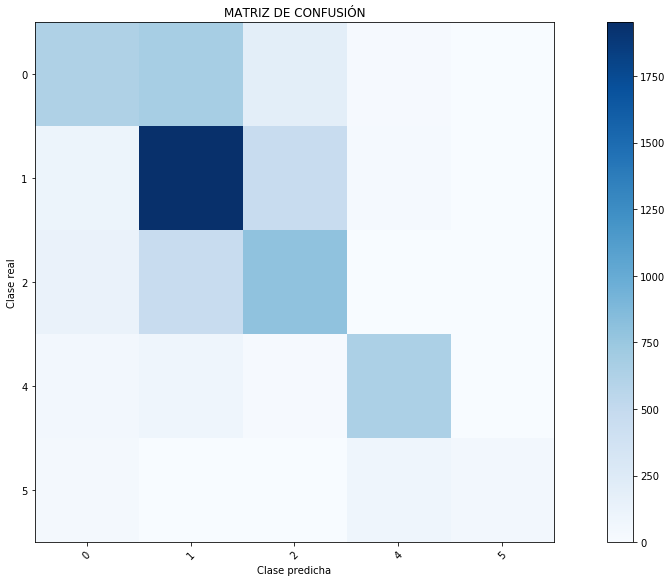

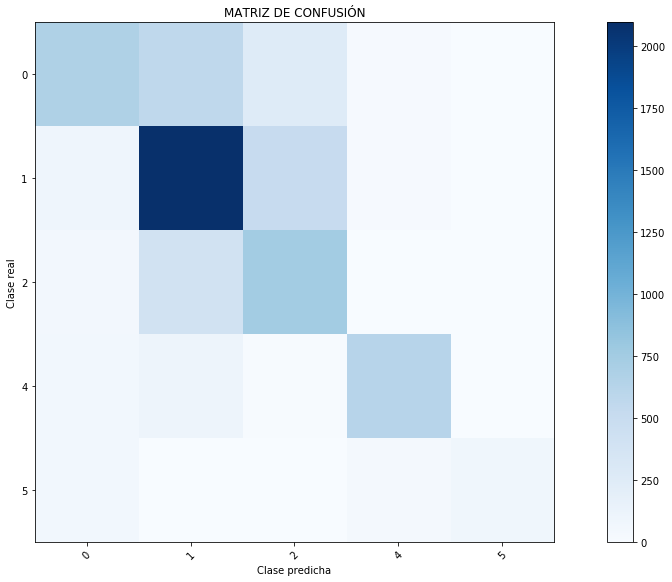

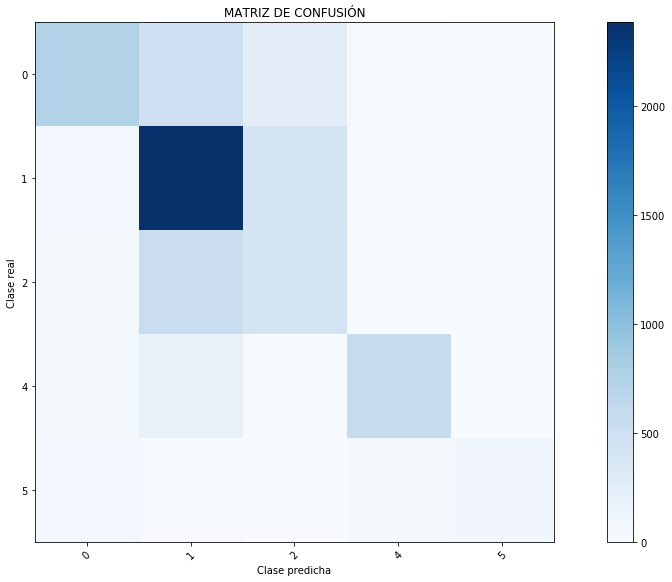

In [24]:
print("#############################")
excercise_2(all_data_1S_filtered, 50)
print("#############################")
excercise_2(all_data_2S_filtered, 50)
print("#############################")
excercise_2(all_data_5S_filtered, 50)
print("#############################")
excercise_2(all_data_10S_filtered, 50)
print("#############################")



#############################
X_train_3: (42313, 8)
X_test_3: (15635, 8)
y_train_3: (42313,)
y_test_3: (15635,)

 _______________________________________________________
confusion matrix: 

[[1677  934  838  132   16]
 [ 259 4249  455   27    0]
 [ 139  865 2496    6    0]
 [  49   76   13 2767    4]
 [  13    0    0    7  613]]

 _______________________________________________________
classification report: 

              precision    recall  f1-score   support

         0.0       0.78      0.47      0.58      3597
         1.0       0.69      0.85      0.76      4990
         2.0       0.66      0.71      0.68      3506
         4.0       0.94      0.95      0.95      2909
         5.0       0.97      0.97      0.97       633

   micro avg       0.75      0.75      0.75     15635
   macro avg       0.81      0.79      0.79     15635
weighted avg       0.76      0.75      0.75     15635

_______________________________________________________
accuracy score: 0.7548448992644707
######

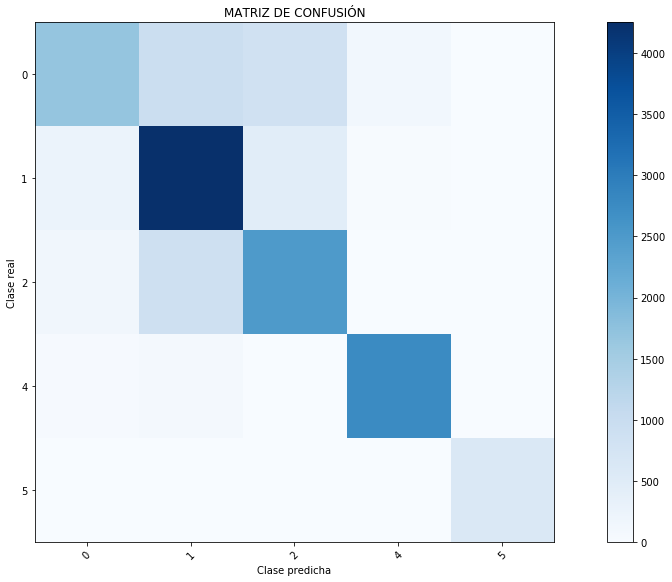

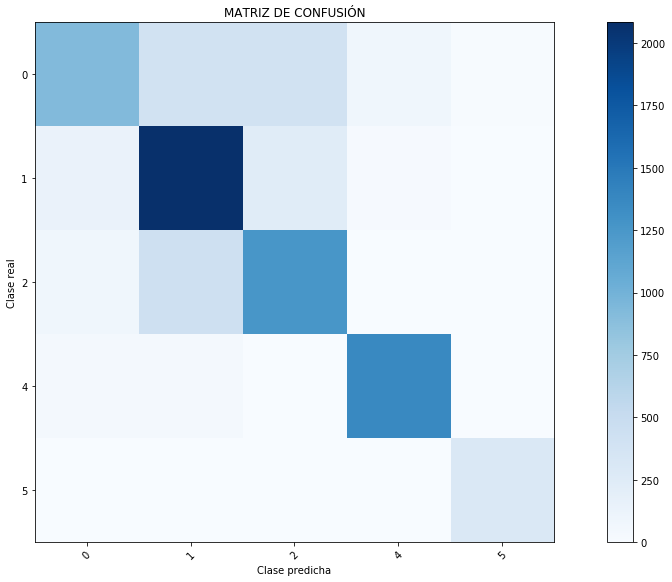

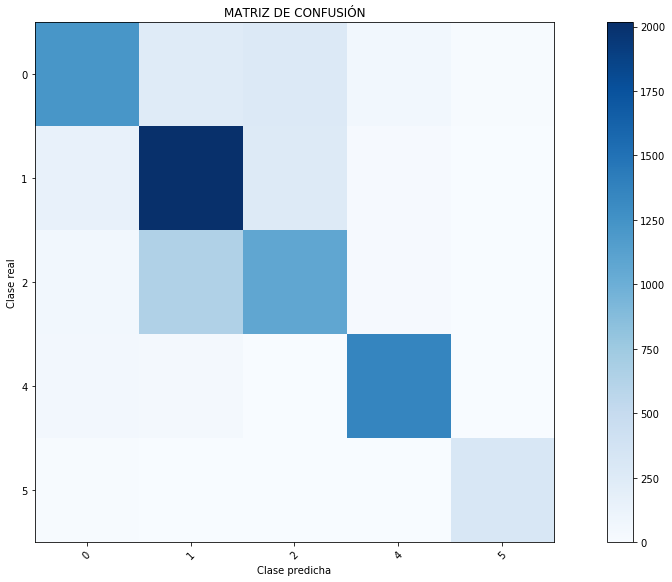

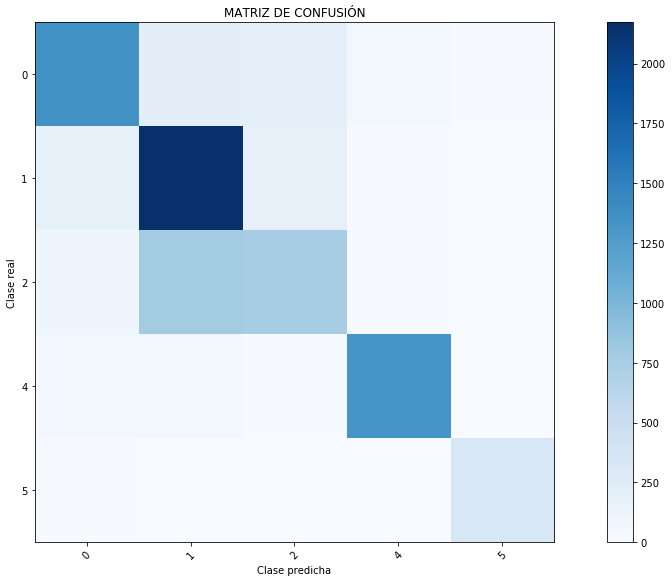

In [25]:
print("#############################")
excercise_3(all_data_1S_filtered, 50)
print("#############################")
excercise_3(all_data_2S_filtered, 50)
print("#############################")
excercise_3(all_data_5S_filtered, 50)
print("#############################")
excercise_3(all_data_10S_filtered, 50)
print("#############################")



# Conclusions:

### According precision and recall metrics, the best answer are with method 1 , where training and test data are taken radomly, by the way the best results appear when the time analyzed is 10 seconds , probably because the activities sequence going the best results over a longer time. 

### Maybe this metric would be reduced if you take more than 10 seconds or as it`s showing in this report you can reduce the effectiveness if you take a litlle less bit time as well.

### If only one place could be selected to put the senssor according to the correlation matrix I would place it on back, which one has a highest level of correlation with other variables (related with acelerometer and innertian) an then this one can give me reliable information , but that would be useful for this analysis. 


### If the smartphone changed it´s orientation , I suposse the answers of this study doesn´t change , because the sensors of the smartphone (accelerometer, gyroscope, magnetometer), can tell you the position of the phone.